# Tutorial #6 Visualizing TimingModel Cores
This tutorial is to guide you through visualizing and analyzing results from a single pulsar, non-linear timing run from `enterprise`.

In [1]:
import os
import sys
import warnings
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
import enterprise
from enterprise.pulsar import Pulsar

import la_forge
from la_forge import utils
from la_forge.core import TimingCore
import la_forge.diagnostics as dg
import la_forge.timing as tm

In [4]:
psr_name = "J1640+2224"

datadir = ('/').join(la_forge.__path__[0].split('/')[:-1])
parfile = f'{datadir}/tests/data/{psr_name}_ng9yr_dmx_DE421.par'
timfile = f'{datadir}/tests/data/{psr_name}_ng9yr_dmx_DE421.tim'

#Core Locations for a standard non-linear timing (NLTM) core and one with advanced noise modeling (ANM)
std_core_loc = f'{datadir}/tests/data/chains/nonlinear_timing/{psr_name}_std_noise'
anm_core_loc = f'{datadir}/tests/data/chains/nonlinear_timing/{psr_name}_adv_noise'

## Load the Pulsar
Make sure the ephemeris is the same as in the parfile and you have to retain the t2pulsar object. If you want to use `PINT` that is also cool, just change the final two kwargs to `drop_pintpsr=False, timing_package="pint"`

In [5]:
psr = Pulsar(parfile,timfile,ephem='DE421',clk=None,drop_t2pulsar=False,timing_package="tempo2",)

## Load TimingCores
Don't forget to include the location of the original timing parameters that you should have saved when initializing the pulsar before sampling with `enterprise`.

In [6]:
burn=0.25
std_core = TimingCore(label='Standard NLTM',
                      chaindir=std_core_loc,
                      tm_pars_path=std_core_loc+'/orig_timing_pars.pkl',
                      burn=burn)

anm_core = TimingCore(label='ANM NLTM',
                      chaindir=anm_core_loc,
                      tm_pars_path=anm_core_loc+'/orig_timing_pars.pkl',
                      burn=burn)

## Check Convergence of Chains
This function checks the autocorrelation of the chains of each parameter and returns the worst value (longest autocorrelation length), which then can be used to calculate the effective number of samples you have in your worst parameter.

It also uses the [Gelman-Rubin split R-hat statistic](https://arxiv.org/pdf/1903.08008.pdf) to also check each parameter for proper convergence.

These chains are not very well converged!

In [7]:
dg.check_convergence([std_core,anm_core])

-------------------------------
core: Standard NLTM
	 lnpost: 120050.431693, lnlike: 120989.384749
	 Can't run Grubin test
Watch Out! J1640+2224_430_PUPPI_efac
Watch Out! J1640+2224_430_PUPPI_log10_equad
Watch Out! J1640+2224_timing_model_A1
Watch Out! J1640+2224_timing_model_COSI
Watch Out! J1640+2224_timing_model_DMX_0001
Watch Out! J1640+2224_timing_model_DMX_0002
Watch Out! J1640+2224_timing_model_DMX_0003
Watch Out! J1640+2224_timing_model_DMX_0004
Watch Out! J1640+2224_timing_model_DMX_0005
Watch Out! J1640+2224_timing_model_DMX_0006
Watch Out! J1640+2224_timing_model_DMX_0007
Watch Out! J1640+2224_timing_model_DMX_0008
Watch Out! J1640+2224_timing_model_DMX_0009
Watch Out! J1640+2224_timing_model_DMX_0010
Watch Out! J1640+2224_timing_model_DMX_0011
Watch Out! J1640+2224_timing_model_DMX_0012
Watch Out! J1640+2224_timing_model_DMX_0013
Watch Out! J1640+2224_timing_model_DMX_0014
Watch Out! J1640+2224_timing_model_DMX_0015
Watch Out! J1640+2224_timing_model_DMX_0016
Watch Out! J16

Watch Out! J1640+2224_timing_model_FD2
Watch Out! J1640+2224_timing_model_FD3
Watch Out! J1640+2224_timing_model_FD4
	 Max autocorrelation length: 2351.7231935929976, Effective sample size: 12.757028583012794



## Investigating a Single Chain
In addition to the usual way of investigating a single core as shown in Tutorial #2, we added a few special methods specific to usefulness with analyzing the timing model posteriors and resulting parameters.
1. Create a summary comparison of timing parameters to the original parameters in the parfile.
   * You can specify different parameters to look at (especially if you don't want all DMX parameters in there) by chaining together the abbreviated names of the parameters. I.e. 'all', or 'kep','mass','gr','spin','pos','noise', 'dm', 'chrom', 'dmx', 'fd' all joined by underscores

In [8]:
print(tm.summary_comparison(psr_name, std_core, selection="kep_pos"))

   Parameter                  Old Value       New Median Value  \
0         A1               55.329720617      55.32971839107948   
1       COSI      0.4857874000743535135     0.5406945544488284   
2        ECC               0.0007972573  0.0007972513598406172   
3       ELAT      0.7689661391921029106     0.7689661387741951   
4      ELONG       4.258412990301330403      4.258412990223339   
5         M2                   0.150233     0.6138985570998517   
6         OM            50.731656477361      50.73133350091245   
7         PB         175.46066190105114     175.46066190260123   
8         PX                     0.7634     0.7722948798457538   
9         T0           55661.7741583016      55661.77400085836   
10      XDOT  1.1381999999999999771e-14         1.14461542e-14   

                    Difference                  Old Sigma  \
0   -2.2259205185795605253e-06   4.915000000000000376e-06   
1      0.054907154374474899286     0.19146885198497040605   
2    -5.9401593828297819

2. A more tailored corner plot that allows for the `selection` functionality.

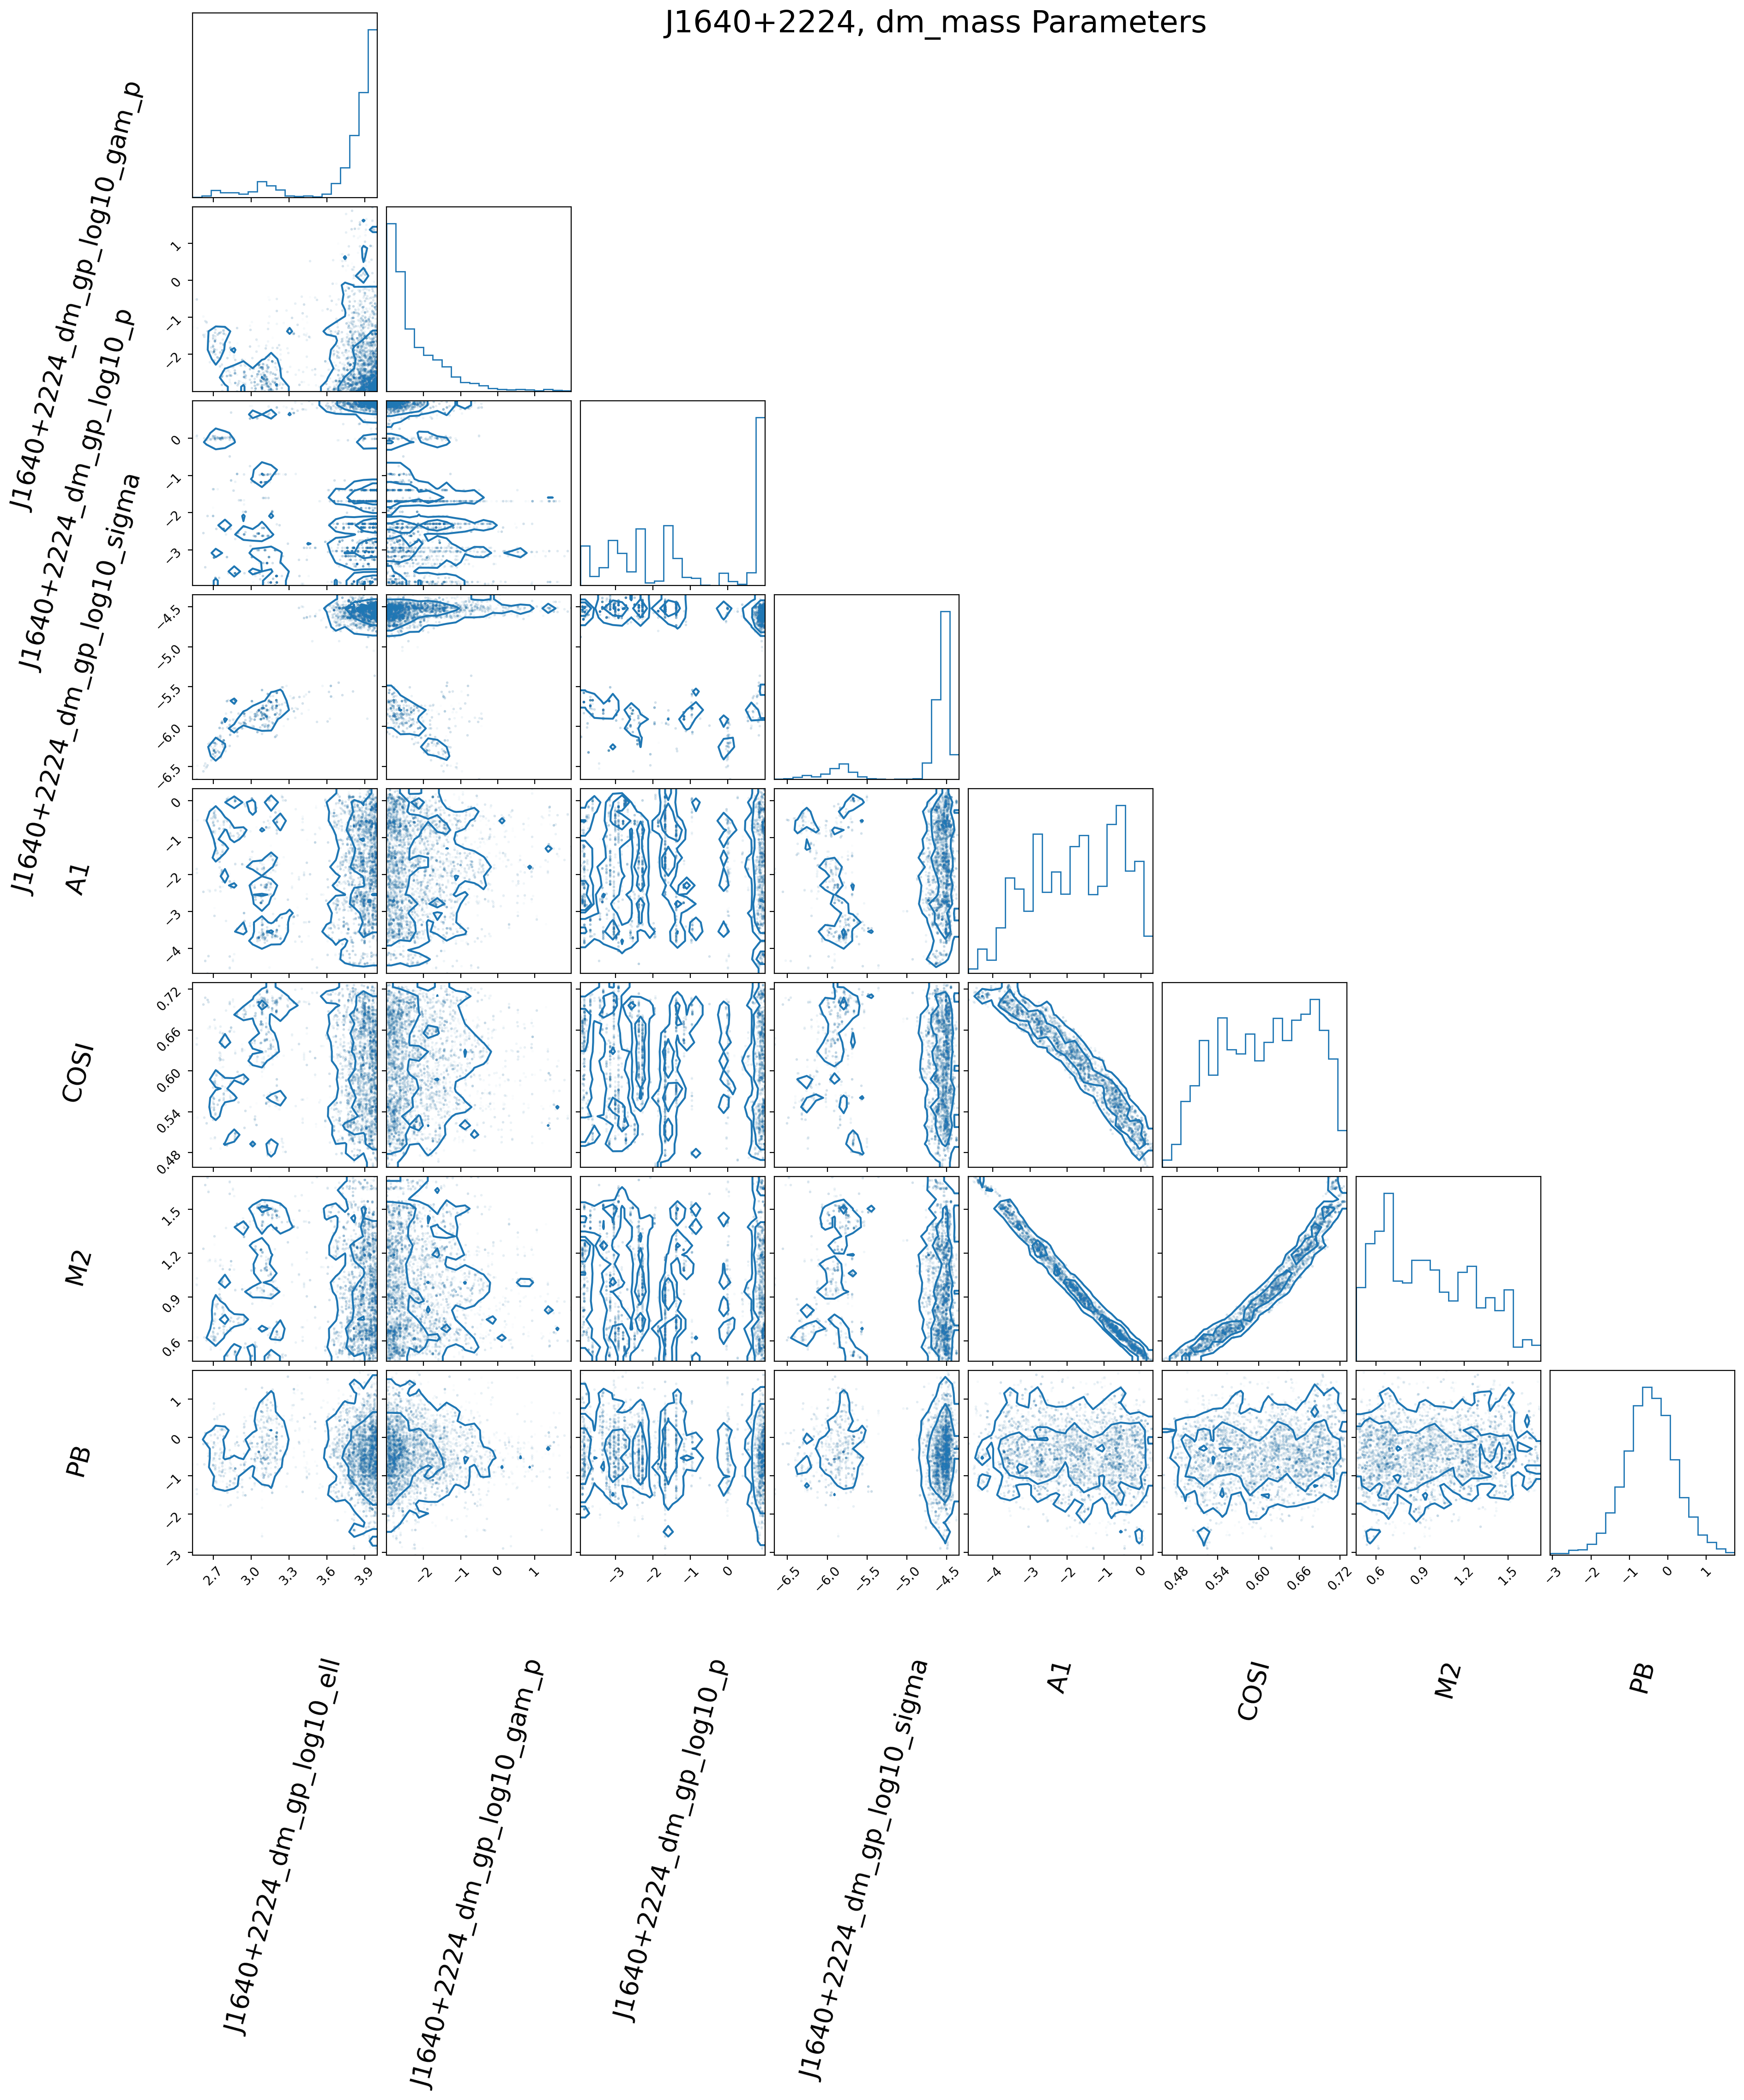

In [9]:
tm.corner_plots(psr_name, anm_core, selection="dm_mass",
                truths=False, corner_label_kwargs={"rotation":75, "fontsize":20})

3. Examining changes in the residuals

The function uses either the mean, median, or maximum a posteriori of each parameter's posterior to calculate new residuals. Since our example is not very converged, the timing model parameters have not settled to their final values, meaning their residuals are pretty different from those of the original parfile values.

Offset not in psr pars
OMDOT not in psr pars


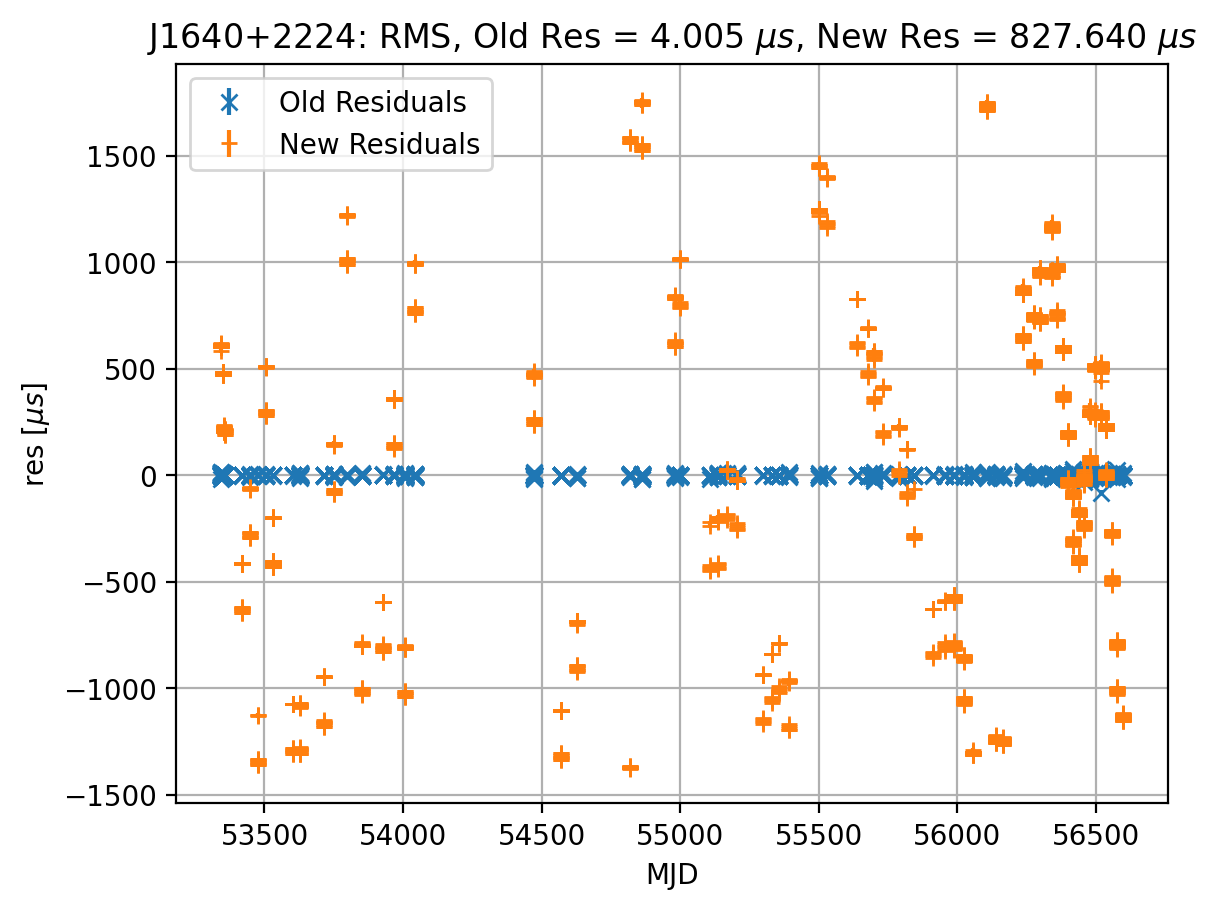

In [10]:
tm.residual_comparison(psr, std_core, use_mean_median_map="median")

## Comparing Multiple Chains
Since the usual plotting in `diagnostics` is mainly used for a single core, we expanded it in a new function to be able to plot only the overlapping parameters between multiple chains.

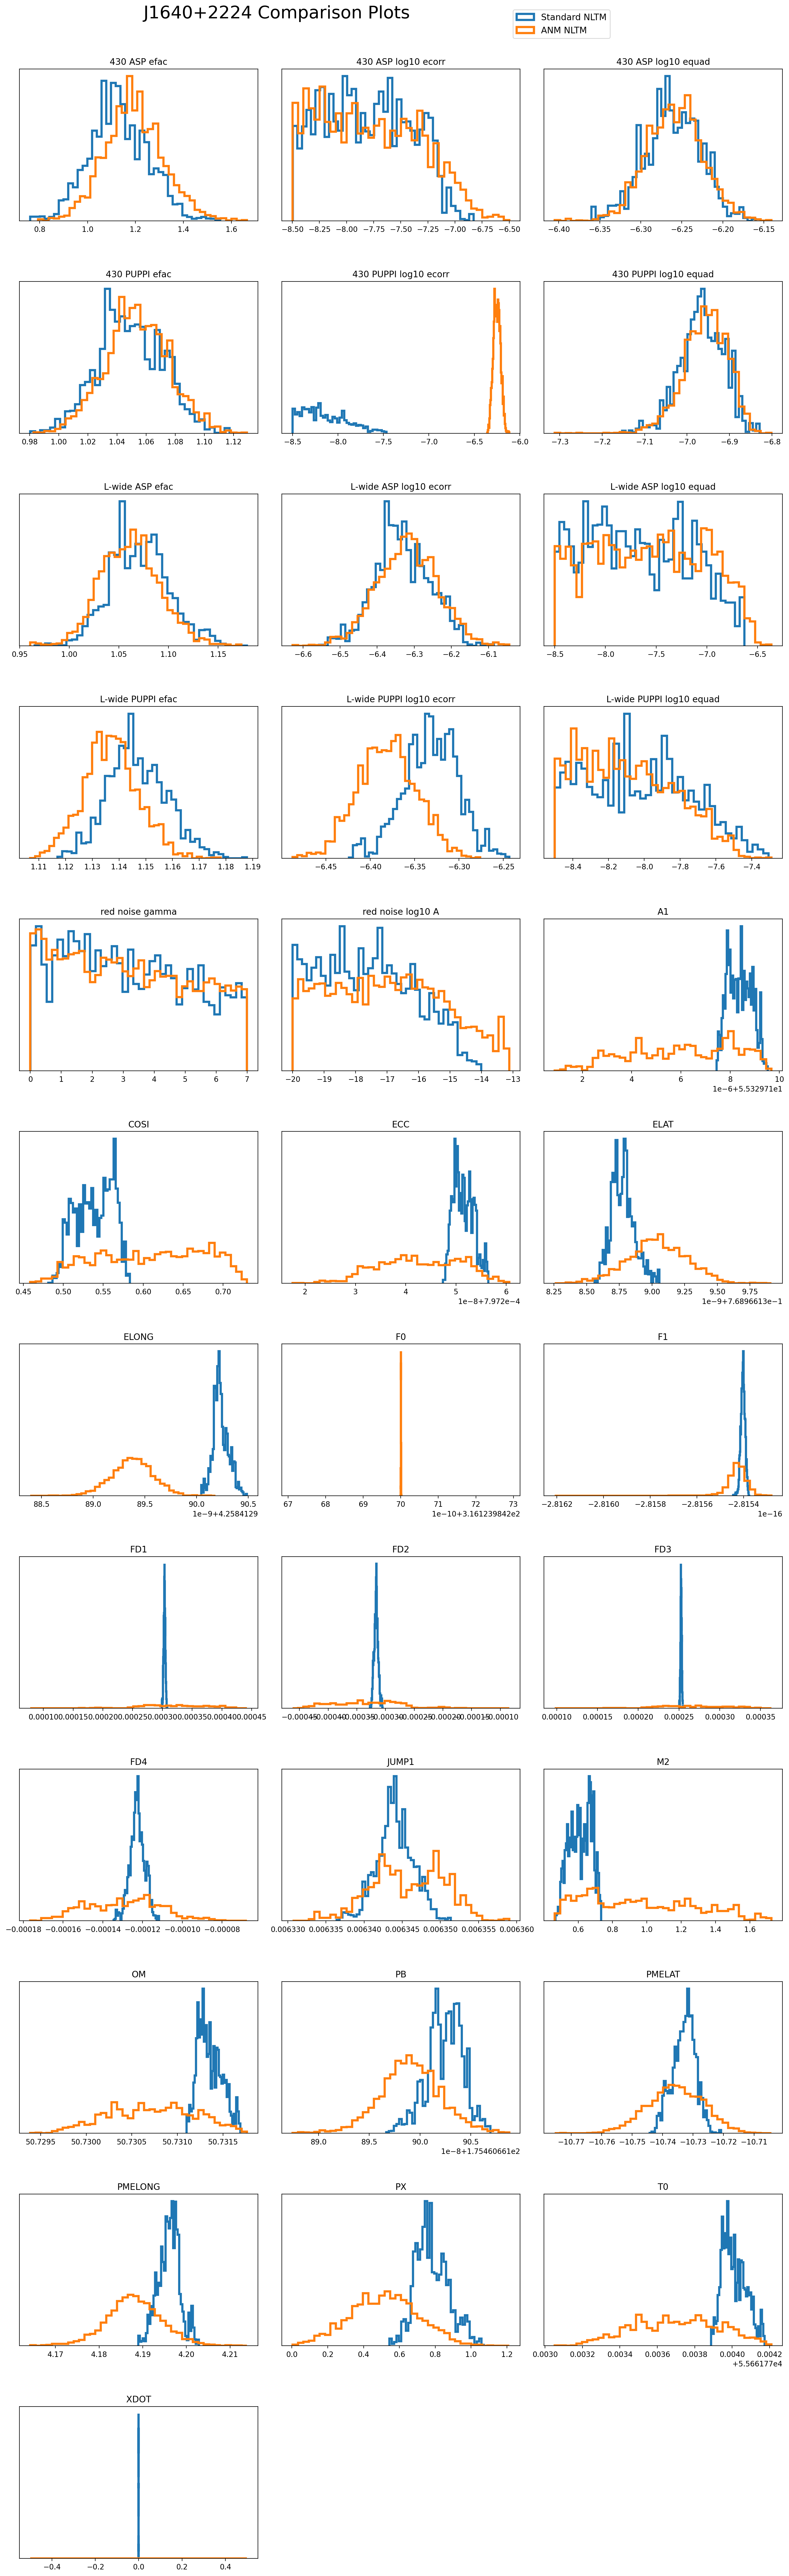

In [11]:
tm.plot_all_param_overlap(psr_name, [std_core, anm_core], fig_kwargs={"suptitleloc":(0.35, 1.02),
                                                                      "legendloc":(0.65, 0.985)})

To plot all the non-overlapping parameters, one would just use the following function. It also supports `selection` and the ability to display the truth values if assigned in `par_sigma`, but since there is perfect overlap in the timing model parameters in this case, we don't use `par_sigma`.

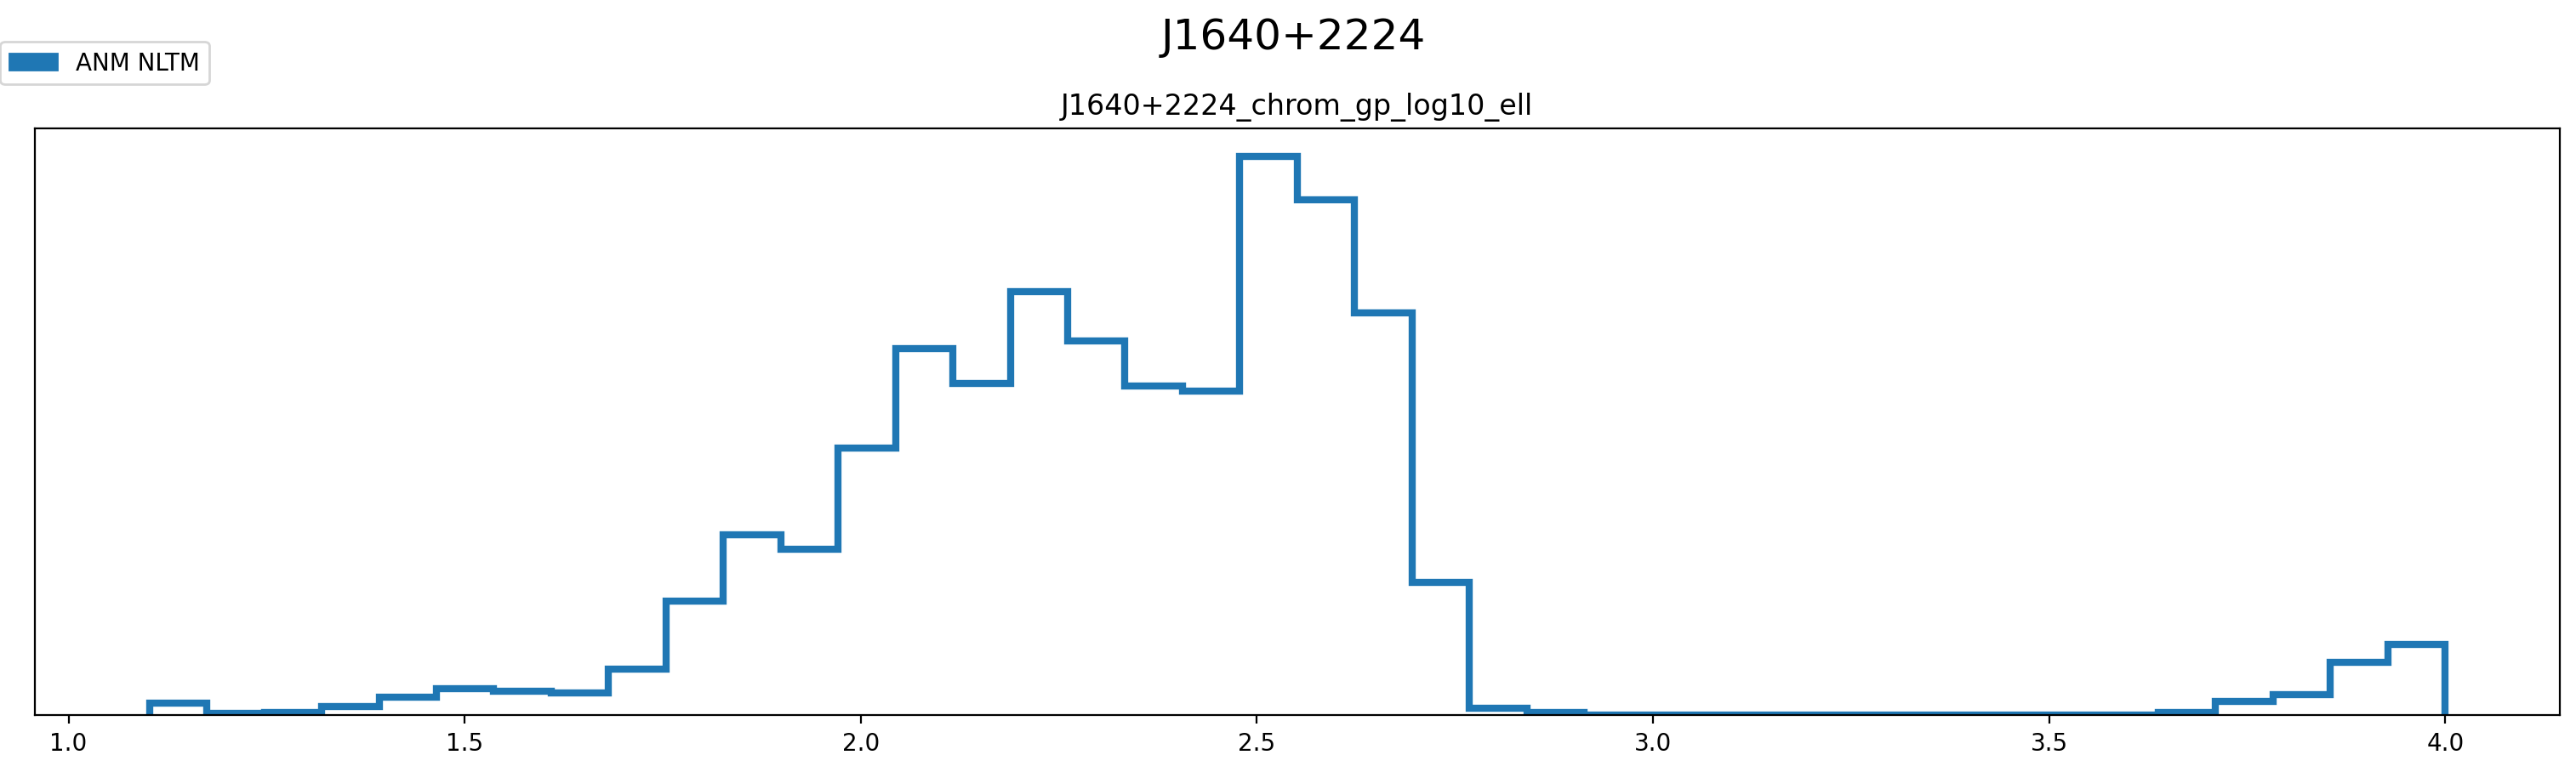

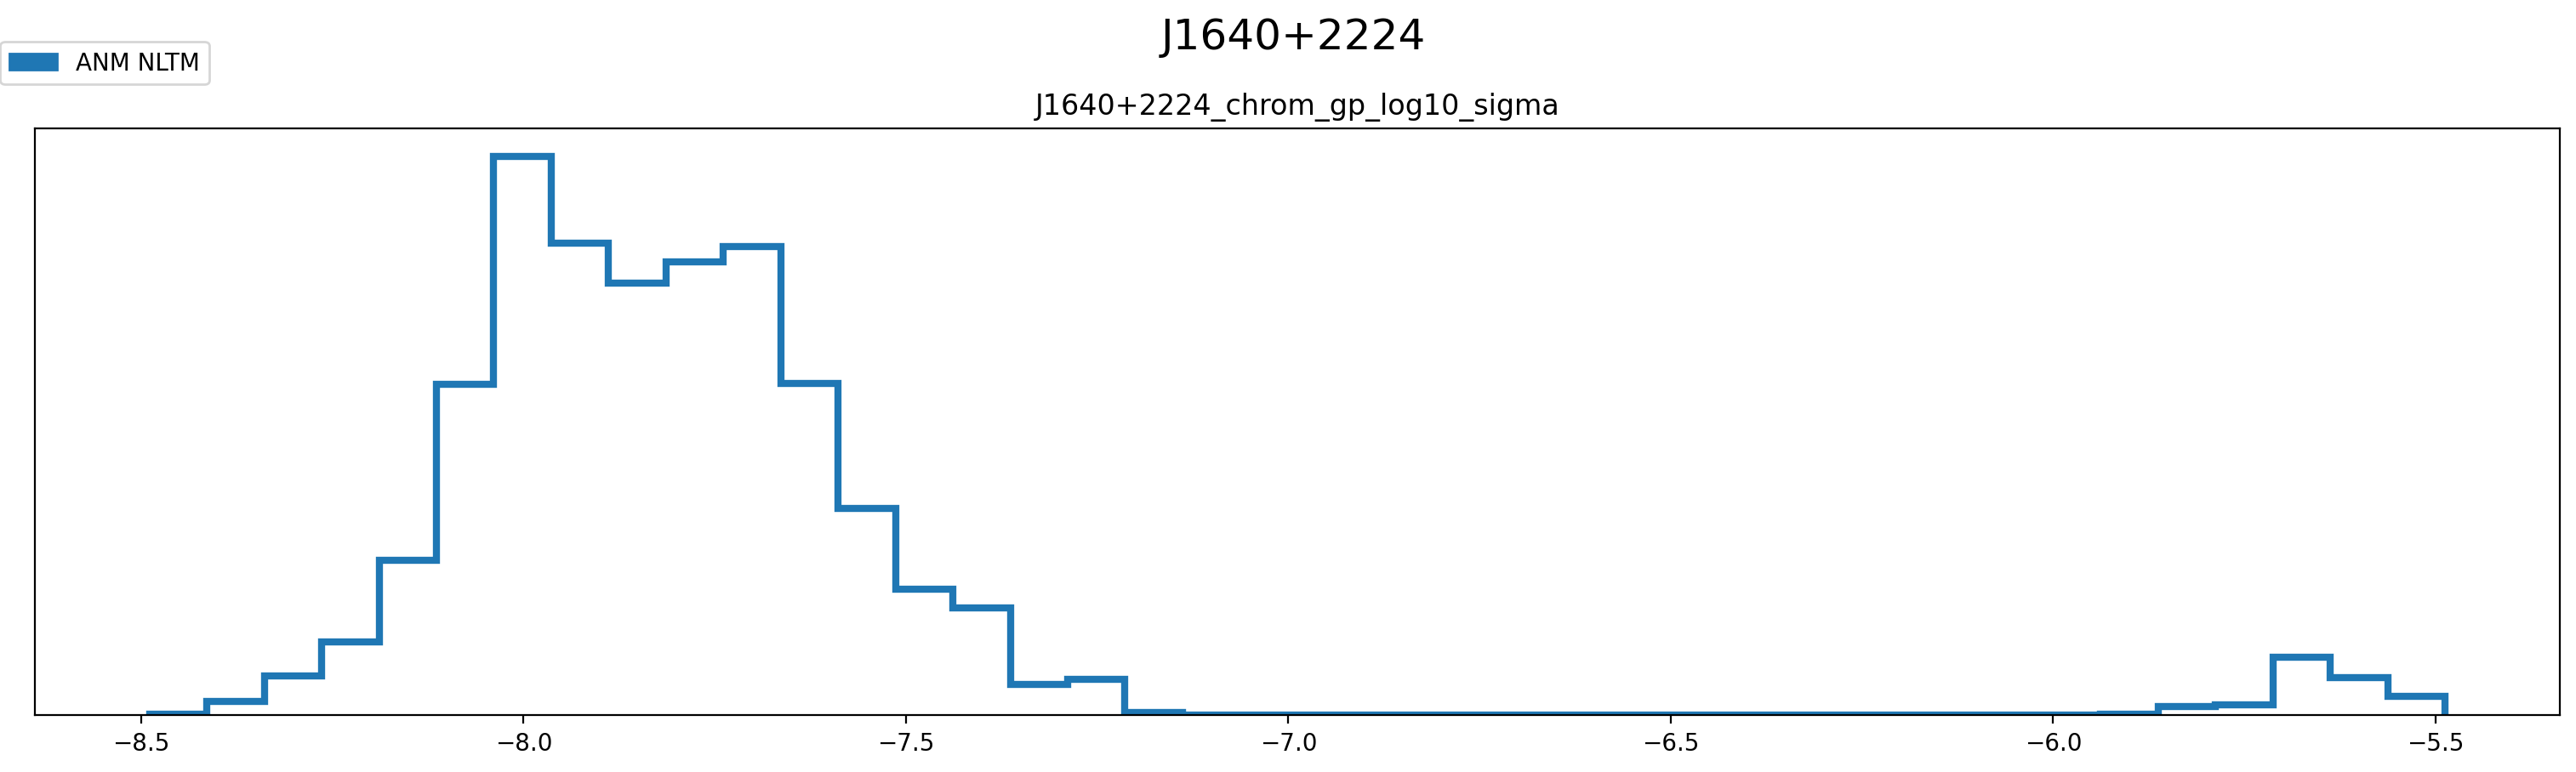

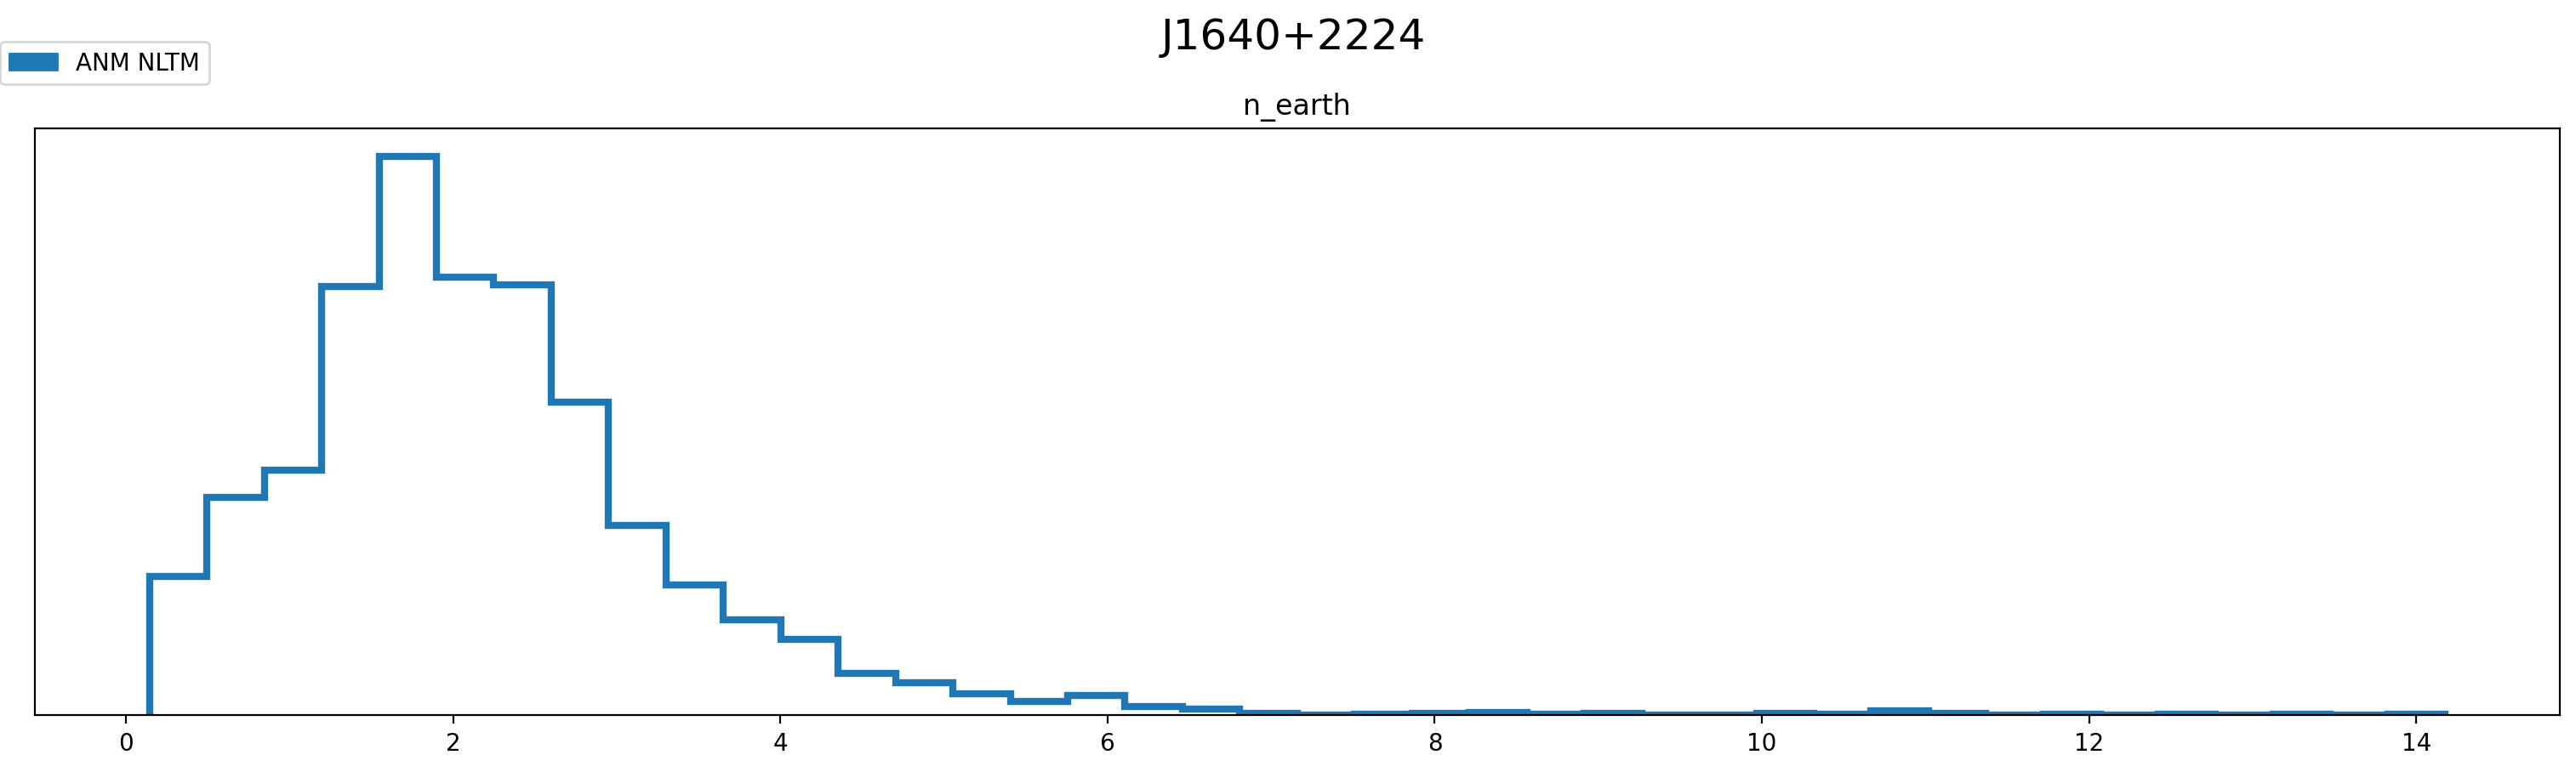

In [12]:
tm.plot_other_param_overlap(psr_name, [std_core, anm_core],
                            selection="chrom")

### Fancy Plotting
For making the labels and display a little nicer to compare multiple cores, use `fancy_plot_all_param_overlap`. As with the other two comparison plotting functions, you can choose to display the timing model parameters in their scaled versions (in terms of sigma, e.g. a value of 1 is one parfile error away from the parfile value) or in their non-scaled version with `real_tm_pars`. This also supports `selection`!

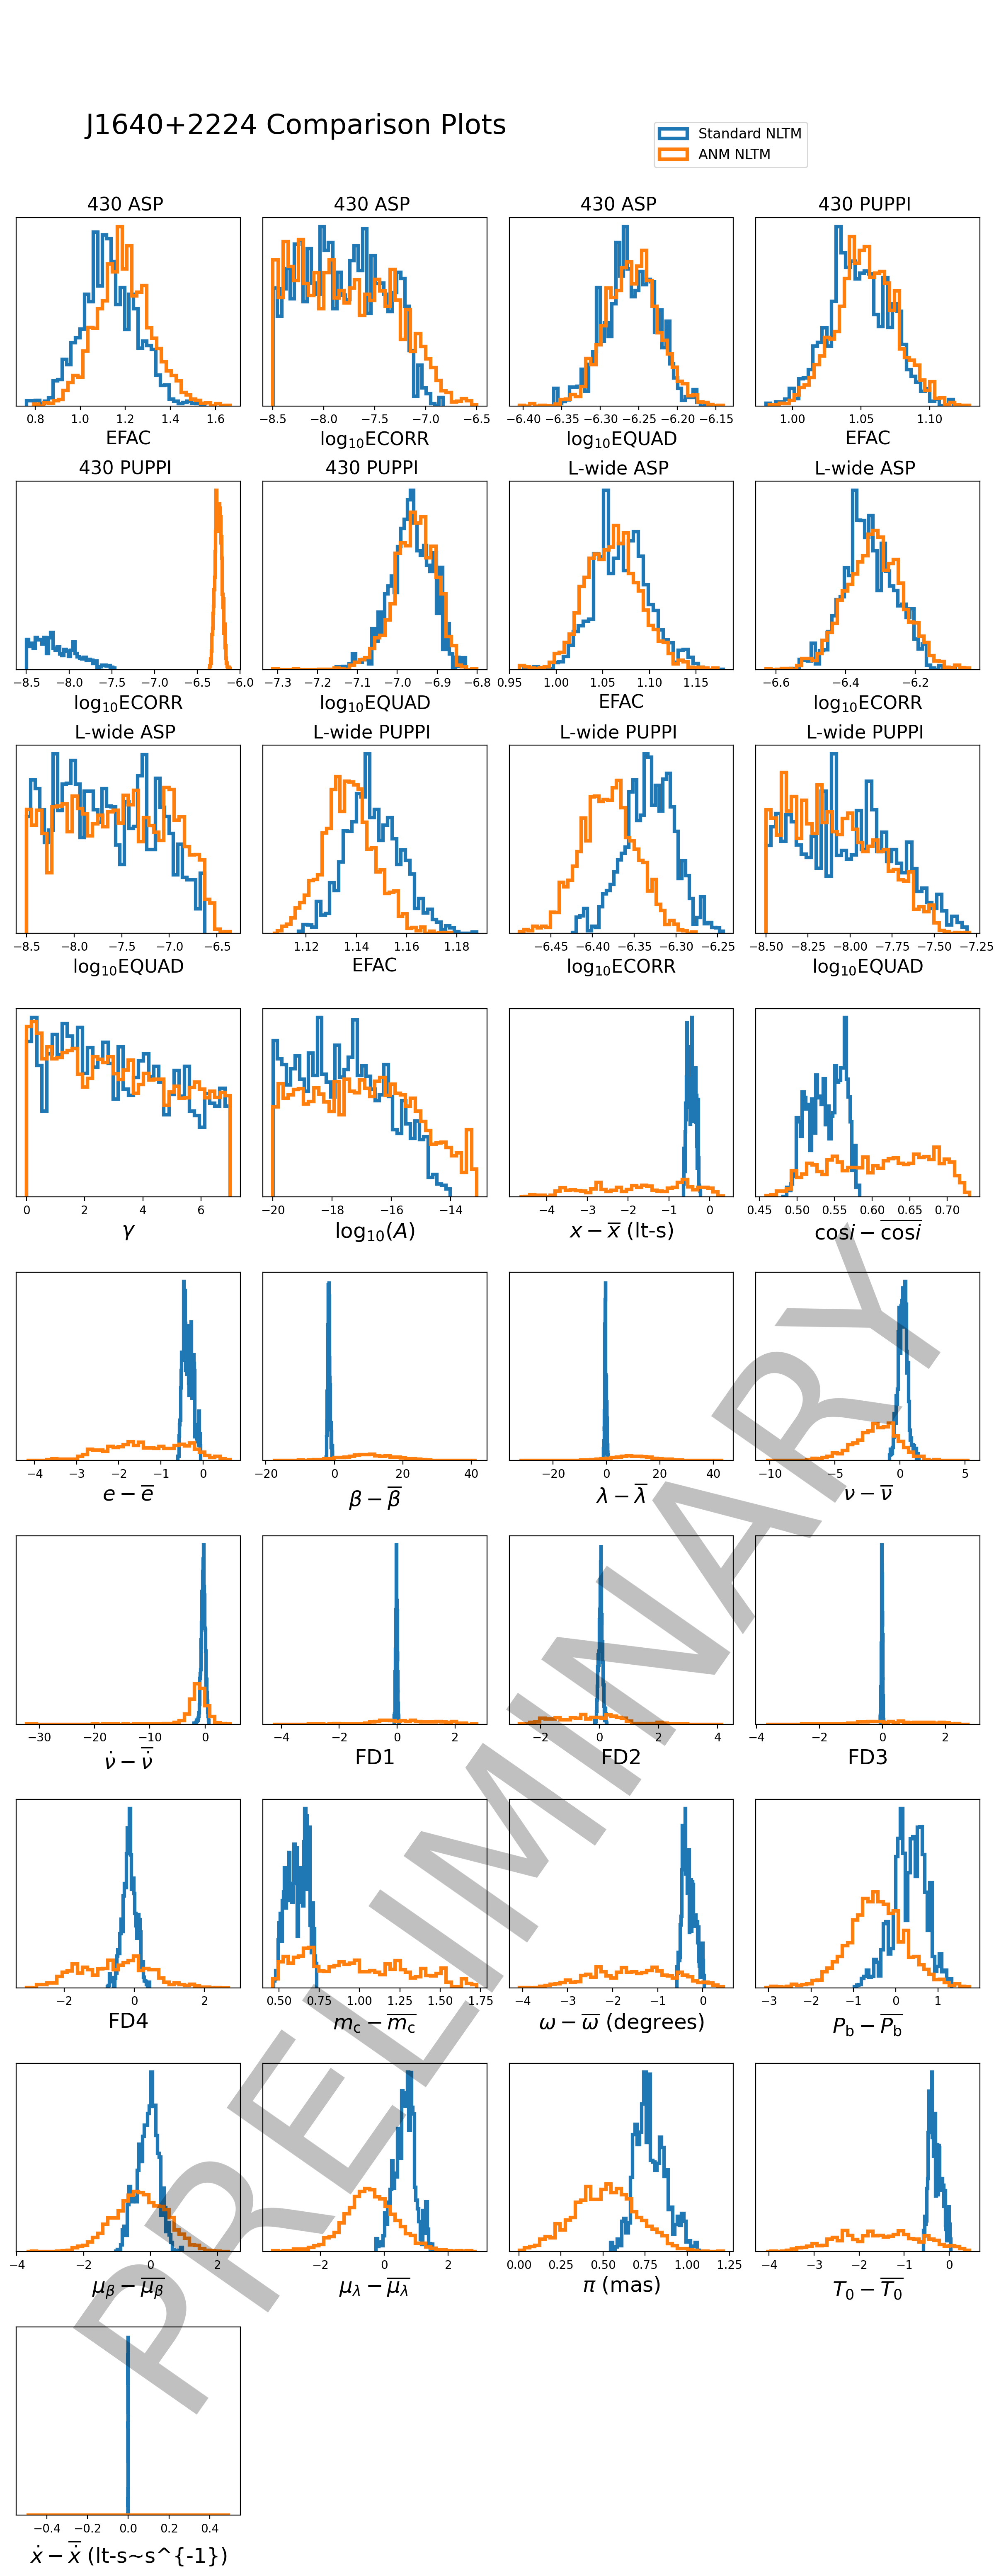

In [13]:
tm.fancy_plot_all_param_overlap(psr_name,[std_core,anm_core], real_tm_pars=False, 
                                fig_kwargs={"suptitleloc":(0.35, 0.915),
                                            "legendloc":(0.65, 0.935)})

### Binary Pulsars

For binary pulsars, it is often useful to plot the mass parameters. Since the pulsar mass is derived using the mass function, this method makes it fairly easy to use the companion mass and inclination angle of the system to calculate the implied pulsar mass. 

It is especially interesting to compare changes in results between different models. In this case, we compare a version that uses Gaussian processes to model the dispersion measure and a model with the usual DMX.

This function has the ability to display the truth values if assigned in `par_sigma`. In this case, we use the parfile values. It can also display the confidence interval regions of each parameter, as well as printing them out.

Standard NLTM
----------------
Pulsar Mass$~(\mathrm{M}_{\odot})$
Median: 4.231845440393451
Lower: 3.571048779316878
Upper: 4.837561819398495
Diff Lower: 0.6607966610765734
Diff Upper: 0.6057163790050435
Rounded Median: 4.2 or 4.2
Rounded Lower: 0.7
Rounded Upper: 0.6

Companion Mass$~(\mathrm{M}_{\odot})$
Median: 0.6138985570998517
Lower: 0.5399712089193538
Upper: 0.6842258810057296
Diff Lower: 0.07392734818049795
Diff Upper: 0.07032732390587781
Rounded Median: 0.61 or 0.61
Rounded Lower: 0.07
Rounded Upper: 0.07

$\mathrm{cos}~i$
Median: 57.26906729865635
Lower: 55.64806635697287
Upper: 59.23087137818909
Diff Lower: 1.6210009416834763
Diff Upper: 1.961804079532748
Rounded Median: 57.0 or 57.0
Rounded Lower: 2.0
Rounded Upper: 2.0

ANM NLTM
----------------
Pulsar Mass$~(\mathrm{M}_{\odot})$
Median: 7.101033676816102
Lower: 4.336358066066241
Upper: 11.234330723551869
Diff Lower: 2.764675610749861
Diff Upper: 4.133297046735767
Rounded Median: 7.0 or 7.0
Rounded Lower: 3.0
Rounded Upper

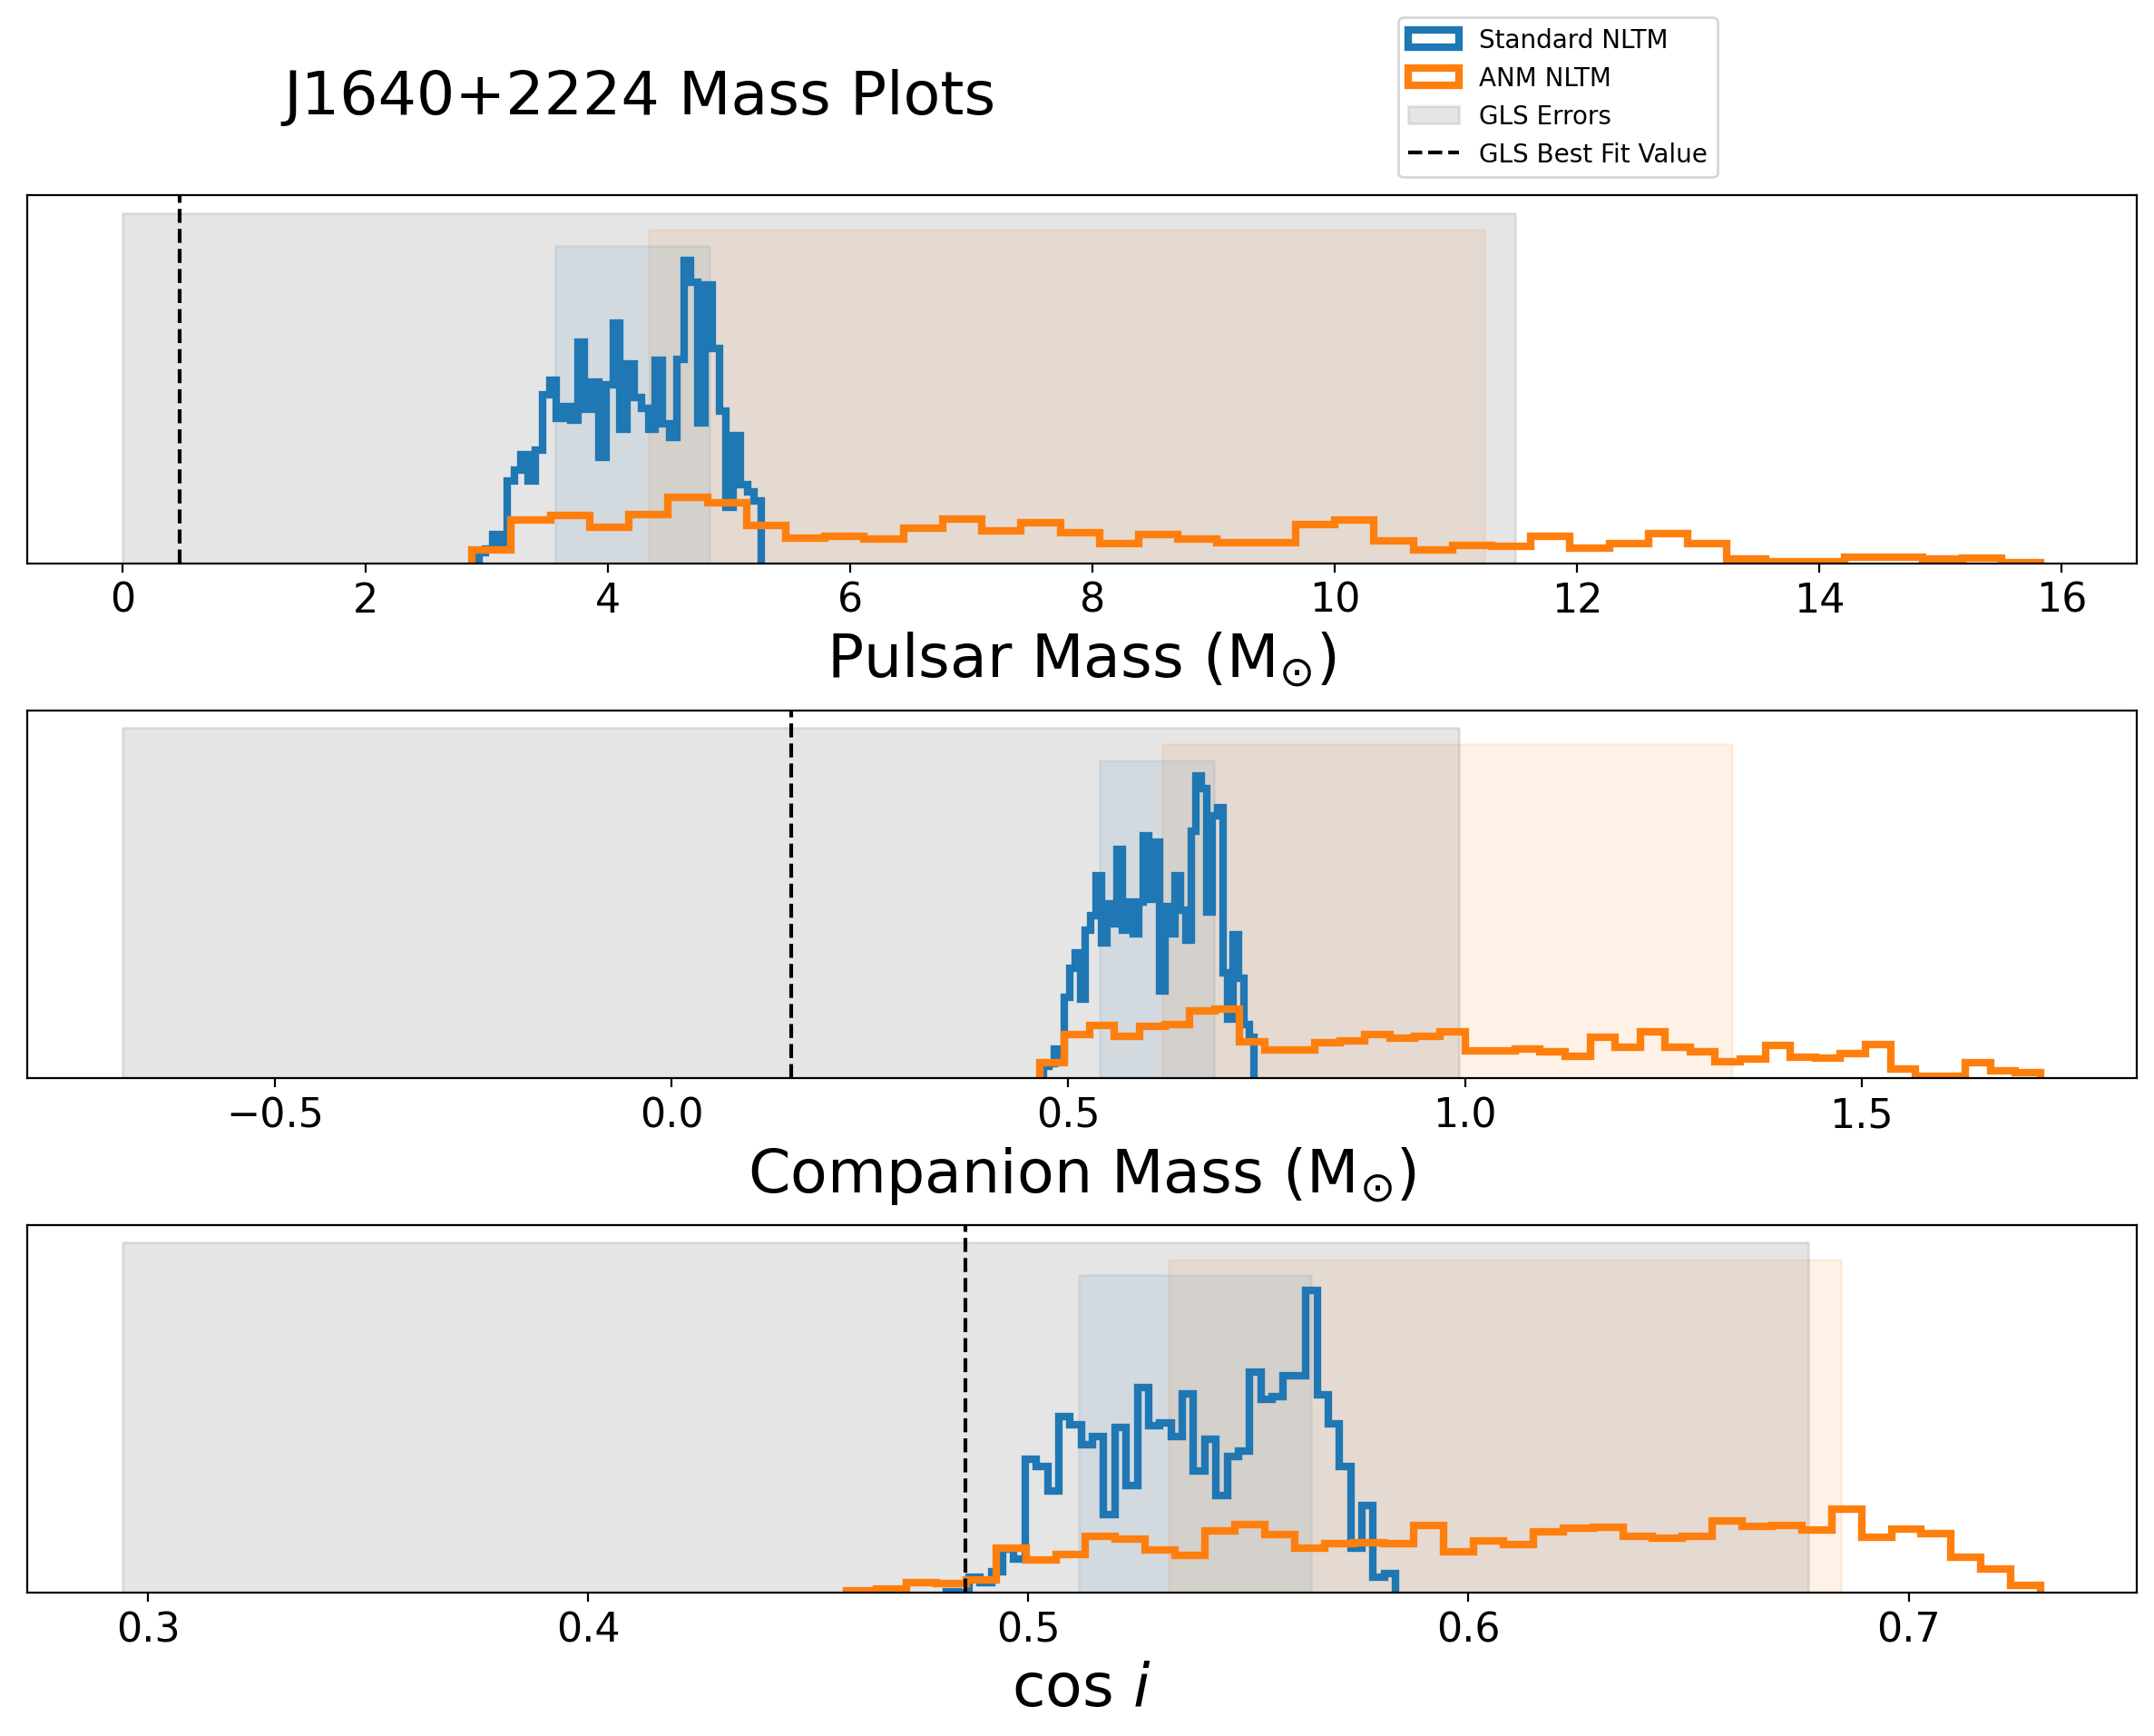

In [14]:
tm.mass_plot(psr_name,[std_core, anm_core], par_sigma=std_core.tm_pars_orig,
             conf_int=68.3, print_conf_int=True, show_legend=False,
             fig_kwargs={"suptitleloc":(0.35,.95)})
fig = plt.gcf()
allaxes = fig.get_axes()
allaxes[0].legend(loc=(.65,1.05))
plt.show()

## Utility Functions
To make it easier to setup an `enterprise` run with DM Gaussian processes, we created a utility function to strip a parfile of its DMX values in the way that the advanced noise modeling runs need when initialized. The function saves the output in the folder the function is run in with the default name of the parfile value given to it.

In [15]:
os.listdir(f'{datadir}/tests/data/')

['J1640+2224_ng9yr_dmx_DE421.tim',
 'J1640+2224_ng9yr_dmx_DE421.par',
 'J1713+0747.pkl',
 'chains',
 'cores']

In [16]:
utils.make_dmx_file(parfile)

In [17]:
os.listdir(f'{datadir}/tests/data/')

['J1640+2224_ng9yr_dmx_DE421.tim',
 'J1640+2224_ng9yr_dmx_DE421.par',
 'J1713+0747.pkl',
 'J1640+2224_ng9yr_dmx_DE421.dmx',
 'chains',
 'cores']